# Mie散乱の理論を実装する

In [ ]:
#import scipy
import numpy as np
import sympy as sym
from scipy.special import legendre,jv,hankel2
import matplotlib.pyplot as plt

In [ ]:
# scipyのintegrateをインポート
from scipy import integrate

# 積分する関数の定義(今回はx^2)
def f(x):
  return x**2

# 上限値と下限値の入力
a = int(input("下限"))
b = int(inpput("上限"))
ans,err = integrate.quad(f,a,b)

ValueError: invalid literal for int() with base 10: ''

### π_n(cosθ)

In [ ]:
def pi_n(n,theta):
    """
    thetaは度数で与えること
    p124中頃の式だとsinθで割っているが、
    これはルジャンドル多項式の変数がcosのときに微分することでsinの項が出てくるため。（おそらく-を忘れている誤植。）
    """
    cos = np.cos(np.radians(theta))
    sin = np.sin(np.radians(theta))
    legendre_func = legendre(n)
    legendre_func_derivative = legendre_func.deriv()
    return legendre_func_derivative(cos)#/sin


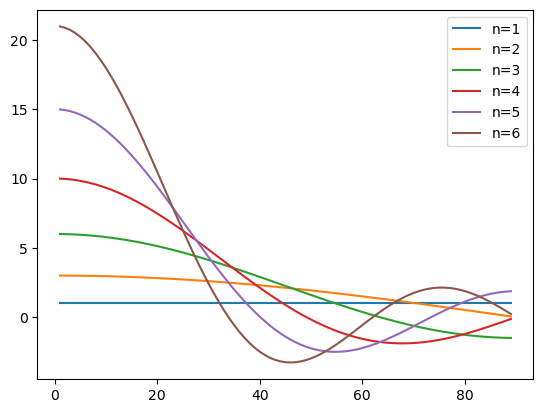

In [ ]:
fig,ax = plt.subplots()
radians = [i for i in range(1,90)]
#radians = [30,60,90]
for i in range(1,7):
    pi = [pi_n(i,radian) for radian in radians]
    ax.plot(radians,pi,label=f"n={i}")
ax.legend()
fig.savefig("../png/pi_n.png")

### τ_n(cosθ)


In [ ]:
def tau_n(n,theta):
    cos = np.cos(np.radians(theta))
    sin = np.sin(np.radians(theta))
    legendre_func = legendre(n)
    legendre_func_derivative = legendre_func.deriv()
    legendre_func_derivative_2 = legendre_func_derivative.deriv()

    return cos * pi_n(n,theta)- sin * legendre_func_derivative_2(cos)# - (cos * legendre_func_derivative(cos) /(sin **2)) - legendre_func_derivative_2(cos)
    #return - sin * legendre_func_derivative_2(cos)
tau_n(6,30)


-37.69335937499999

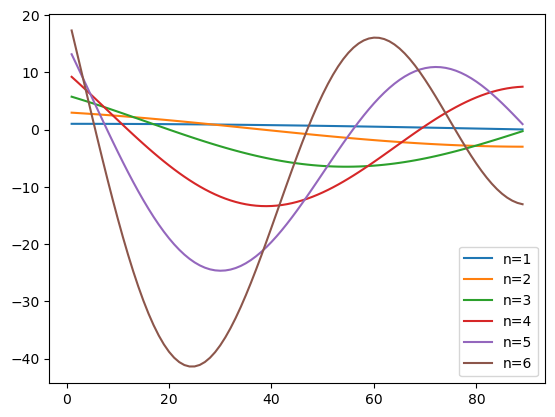

In [ ]:
fig,ax = plt.subplots()
radians = [i for i in range(1,90)]
for i in range(1,7):
    tau = [tau_n(i,radian) for radian in radians]
    ax.plot(radians,tau,label=f"n={i}")
ax.legend()
fig.savefig("../png/tau_n.png")

### psi_n

In [ ]:
def psi_n(n,x):
    """
    psi_n is a key function of an and bn
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    a(float):The diameter of a single particle 
    """
    bessel = jv(n+1/2, x)
    return np.sqrt(np.pi*x/2)*bessel

def xi_n(n,x):
    """
    xi_n is a key function of an and bn
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    a(float):The diameter of a single particle 
    """
    bessel = hankel2(n+1/2, x)
    return np.sqrt(np.pi*x/2)*bessel

In [ ]:
def diff_f(f,n,x, h):
    """
    psi_n,xi_nの数値微分用の関数。hを決めると微分係数の近似値が出る。
    bessel関数なので数値微分するしかない
    f(func): function you want to deriverate
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    h(float): h for limit h→0 (h should be near 0)
    """
    return (f(n,x+h)-f(n,x-h))/(2.0*h)

In [ ]:
#from scipy.misc import derivative
# scipy.misc.derivative(func, x0, dx=1.0, n=1, args=(), order=3)

#ans = scipy.misc.derivative(f, 3, 1.0E-6)
def a_n(n,x,y,m,h=1e-6):
    """
    S1(θ),S2(θ)を求めるための関数。
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?):refractive index (complex?) or real part?
    """
    psi_derivative_x = diff_f(psi_n,n,x,h) #psiのx=xでの微分係数
    xi_derivative_x = diff_f(xi_n,n,x,h)#xiのx=xでの微分係数
    psi_derivative_y = diff_f(psi_n,n,y,h)#psiのy=yでの微分係数
    #xi_derivative_y = diff_f(xi_n,n,y,h)

    numerator = psi_derivative_y * psi_n(n,x) - m * psi_n(n,y) *psi_derivative_x # anの分子
    denominator = psi_derivative_y * xi_n(n,x) - m * psi_n(n,y) *xi_derivative_x # anの分母
    
    return numerator/denominator

def b_n(n,x,y,m,h=1e-6):
    """
    S1(θ),S2(θ)を求めるための関数。
    n(int): the order of the bessel function
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?):refractive index (complex?) or real part?   
    """
    psi_derivative_x = diff_f(psi_n,n,x,h)
    xi_derivative_x = diff_f(xi_n,n,x,h)
    psi_derivative_y = diff_f(psi_n,n,y,h)
    #xi_derivative_y = diff_f(xi_n,n,y,h)

    numerator = m * psi_derivative_y * psi_n(n,x) -  psi_n(n,y) *psi_derivative_x
    denominator = m * psi_derivative_y * xi_n(n,x) -  psi_n(n,y) *xi_derivative_x
    
    return numerator/denominator

In [ ]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023
a_n(3,x,m*x,m)

(0.10455757282611454+0.30598249423231233j)

### S_1(θ), S_2(θ)

In [ ]:
def S_1(theta,x,y,m,nmax=30):
    """
    S1(θ)を求めるための関数。
    theta(int): 散乱角。入射角の方向が0度である。
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?): refractive index (complex?) or real part?  
    nmax(int,optional): since this function is infinite series, the upper limit for iteration should be determined.
    """
    sum = 0
    for n in range(1,nmax):
        numerator_1 = 2*n+1
        numerator_2 = a_n(n,x,y,m) * pi_n(n,theta) + b_n(n,x,y,m) * tau_n(n,theta)
        denominator = n * (n+1)
        #print( numerator_1,numerator_2,denominator)
        sum += (numerator_1*numerator_2)/denominator
    return sum

In [ ]:
def S_2(theta,x,y,m,nmax=30):
    """
    S2(θ)を求めるための関数。
    theta(int): 散乱角。入射角の方向が0度である。
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?): refractive index (complex?) or real part?  
    nmax(int,optional): since this function is infinite series, the upper limit for iteration should be determined.
    """
    sum = 0
    for n in range(1,nmax):
        numerator_1 = 2*n+1
        numerator_2 = b_n(n,x,y,m) * pi_n(n,theta) + a_n(n,x,y,m) * tau_n(n,theta)
        denominator = n * (n+1)
        sum += (numerator_1*numerator_2)/denominator
    return sum    

In [ ]:
def cal_abs(theta,x,y,m):
    """
    i_1,i_2を求める。S1,S2は虚数なので絶対値の二乗を求める。これにより実数となる。
    theta(int): 散乱角。入射角の方向が0度である。
    x(float): x= 2pi・a/λ
    y(float):y = mka
    m(float or complex?): refractive index (complex?) or real part?  
    
    return:
        i_1,i_2 (tuple)
    """
    i_1 = abs(S_1(theta,x,y,m)) ** 2
    i_2 = abs(S_1(theta,x,y,m)) ** 2
    return i_1,i_2

In [ ]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023

散乱角は入射方向を0度として、0~180度で全散乱を計算している。
後方散乱に変更するには90-180だけを計算すればよい？

### 強度I

In [ ]:
def Intensity(I0,theta,x,y,a,m,r):
    i_1,i_2 = cal_abs(theta,x,y,m)
    k = x/a
    numerator = I0 * (i_1+i_2)
    denominator = 2 * (k**2) * (r**2)

    return numerator/denominator

### Efficiency Factor Qsca and Qbacksca

In [34]:
from scipy import integrate
def Qsca(x,y,m):
    def integrate_scattering(theta):
        return (cal_abs(theta,x,y,m)[0] + cal_abs(theta,x,y,m)[0]) * np.sin(np.radians(theta)) #thetaのいち変数とするための関数。

    integrated,err = integrate.quad(integrate_scattering,0,np.pi) #sympyの数値積分メソッドを使用。同時に推定誤差も返される。
    return integrated/(x**2)

In [35]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023
Qsca(x,m*x,m)

0.6850070559013296

### Backscattering

In [36]:
def Qbsca(x,y,m):
    def integrate_scattering(theta):
        return (cal_abs(theta,x,y,m)[0] + cal_abs(theta,x,y,m)[0]) * np.sin(np.radians(theta))

    integrated,err = integrate.quad(integrate_scattering,np.pi/2,np.pi)
    return integrated/(x**2)

In [37]:
x = 2*np.pi*1e-6/(440*1e-9)
m = 1.023
Qbsca(x,m*x,m)

0.40225176973462956